In [65]:
import torch
from pathlib import Path
from notebooks.utils import get_model, load_model_from_config
from ldm.util import instantiate_from_config
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import default_collate
from ldm.models.diffusion.plms import PLMSSampler
from torchvision.utils import make_grid
from einops import rearrange
from PIL import Image

In [2]:
device = torch.device("cuda:0")

In [3]:
# sampling params

batch_size = 8
scale = 2

sampler = PLMSSampler(model)
ddim_steps = 50
shape = [3,64,64]

In [4]:
# load pretrained weights
model_path = Path("../logs/brca_hipt_20x/")
model, config = get_model(model_path, device, "last.ckpt")

Loading model from ../logs/brca_hipt_20x/checkpoints/last.ckpt


/home/ysrikar/miniconda3/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 960, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 960, conte

In [31]:
data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
data.batch_size = batch_size

data.datasets['train'].p_uncond = 0
data.datasets['train'].aug = 0
ds = data.datasets['train']

In [32]:
idx = np.random.randint(0, len(ds), 100)
items = [ds[i] for i in idx]

for item in items:
    item['image'] = (127.5*(item['image'] + 1)).astype(np.uint8)

    del item['feat_5x']
    del item['human_label']

In [33]:
import pickle

In [34]:
with open("./dataset_samples/brca_hipt_patches.pickle", "wb") as f:
    pickle.dump(items, f)

## Sample new images

In [58]:
with open("./dataset_samples/brca_hipt_patches.pickle", "rb") as f:
    items = pickle.load(f)

In [59]:
batch = default_collate(items[:batch_size])

In [64]:
with torch.no_grad(), model.ema_scope():

    batch["feat_20x"] = batch["feat_20x"].to(device)

    batch_uncond = {**batch}
    batch_uncond["feat_20x"] = torch.zeros_like(batch["feat_20x"])

    cc = model.get_learned_conditioning(batch)
    uc = model.get_learned_conditioning(batch_uncond)

    samples_ddim, _ = sampler.sample(
        S=ddim_steps,
        conditioning=cc,
        batch_size=batch_size,
        shape=shape,
        verbose=False,
        unconditional_guidance_scale=scale,
        unconditional_conditioning=uc,
    )

    x_samples_ddim = model.decode_first_stage(samples_ddim)
    x_samples_ddim = torch.clamp(
        (x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0
    )
    x_samples_ddim = (x_samples_ddim * 255).to(torch.uint8)
    x_samples_ddim = x_samples_ddim.cpu()
    samples_real = batch["image"].permute(0,3,1,2)


In [78]:
grid_real =  rearrange(make_grid(samples_real, nrow=8), 'c h w -> h w c').cpu().numpy()
grid_syn =  rearrange(make_grid(x_samples_ddim, nrow=8), 'c h w -> h w c').cpu().numpy()

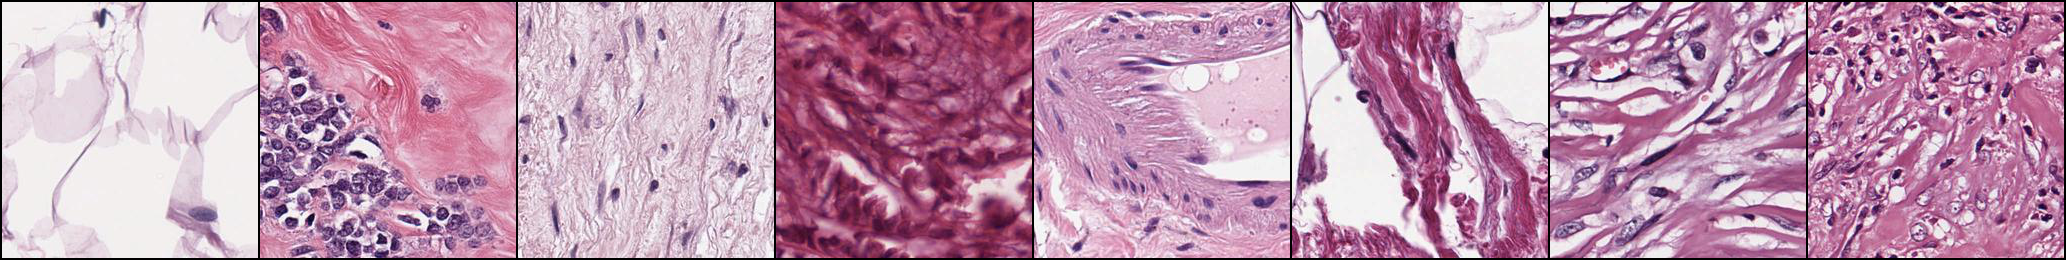

In [85]:
# real images

Image.fromarray(grid_real)

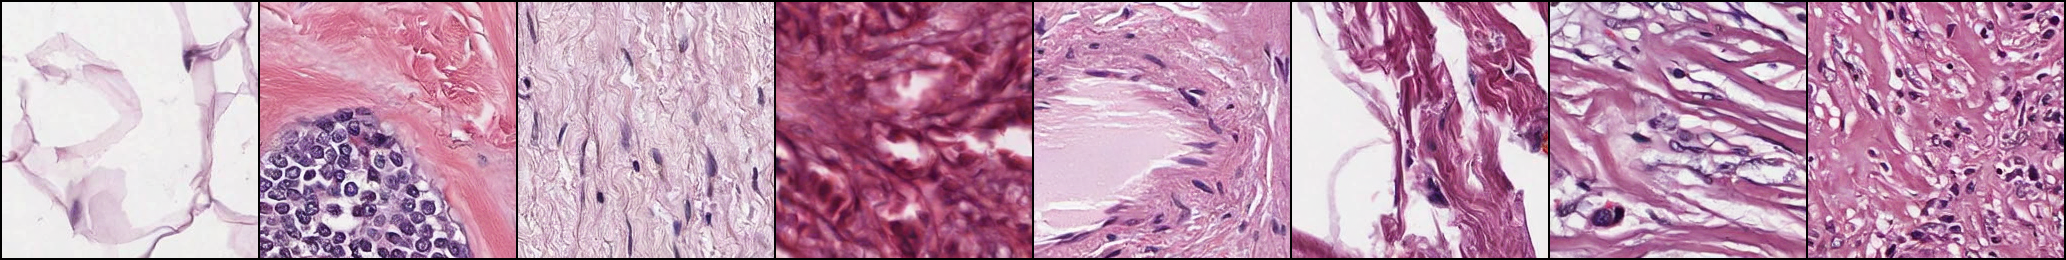

In [86]:
# synthetic images


Image.fromarray(grid_syn)